In [10]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt


In [3]:
image_path = 'data/images/CatDog/'

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if img_gray is not None:
            images.append(img_gray)
    return images
    

In [4]:
imgs = load_images_from_folder(image_path)

In [36]:
print(f"Total images: {len(imgs)}")
print(f"Shape of each image: {imgs[0].shape}")

Total images: 110
Shape of each image: (64, 64)


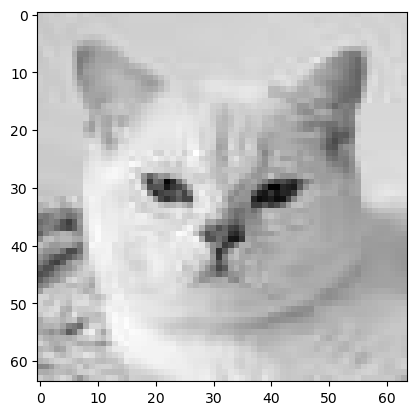

In [6]:
plt.imshow(imgs[0], cmap='gray')

In [13]:
imgs_flatten = np.array([img.reshape(-1) for img in imgs])
print(f"Images after flattening: {imgs_flatten.shape}")

Images after flattening: (110, 4096)


To perform PCA we need to calculate covariance first

In [18]:

def get_covariance_matrix(data):
    mean = np.mean(data, axis=0)
    data = data - mean
    covariance_matrix = np.dot(data.T, data) / (data.shape[0] - 1)
    return covariance_matrix

In [19]:
covariance_matrix = get_covariance_matrix(imgs_flatten)
print(f"Covariance matrix shape: {covariance_matrix.shape}")

Covariance matrix shape: (4096, 4096)


In [35]:
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

Let take only 100 biggest real eigenvalues with their corresponding eigenvectors

In [80]:
# take only real eigenvalues and corresponding eigenvectors
real_eigenvalues = np.real(eigenvalues[np.isreal(eigenvalues)])
corresponding_eigenvectors = np.real(eigenvectors[:,np.isreal(eigenvalues)])
# take top 100 biggest eigenvalues with corresponding eigenvectors
idx = real_eigenvalues.argsort()[::-1]
biggest_eigenvalues = real_eigenvalues[idx][:100]
corresponding_eigenvectors = corresponding_eigenvectors[:,idx][:,:100]


In [83]:
print(f'20 largest eigenvalues:\n{biggest_eigenvalues[:20]}')
print(f'\n 20 corresponding eigenvectors:\n{corresponding_eigenvectors[:20]}')

20 largest eigenvalues:
[3675324.35461076 2315301.35757446 1395841.0287346  1097115.4769348
  774368.79885627  626446.51061228  454381.17127806  379991.04854674
  359777.14917339  347782.67853328  267037.28154634  256912.10964299
  237484.86171538  226082.99052355  202747.7380929   189908.35292088
  164382.31690879  156611.31070443  151594.44268177  145702.48148271]

 20 corresponding eigenvectors:
[[ 0.01587784 -0.01180479 -0.01883917 ...  0.00898878 -0.02464242
  -0.0032831 ]
 [ 0.01683245 -0.01325383 -0.01534047 ...  0.0014225  -0.03128623
   0.00214882]
 [ 0.01663357 -0.01198153 -0.01705236 ...  0.00532489 -0.01464541
  -0.00117331]
 ...
 [ 0.01860056 -0.02579558 -0.01442186 ... -0.01595336  0.00313543
  -0.04235359]
 [ 0.01972388 -0.02593885 -0.01372466 ... -0.01533983 -0.02073456
  -0.04361535]
 [ 0.02046739 -0.02671396 -0.01324486 ... -0.04028402 -0.04012424
   0.00363253]]


Let see what eigenvectors contain!

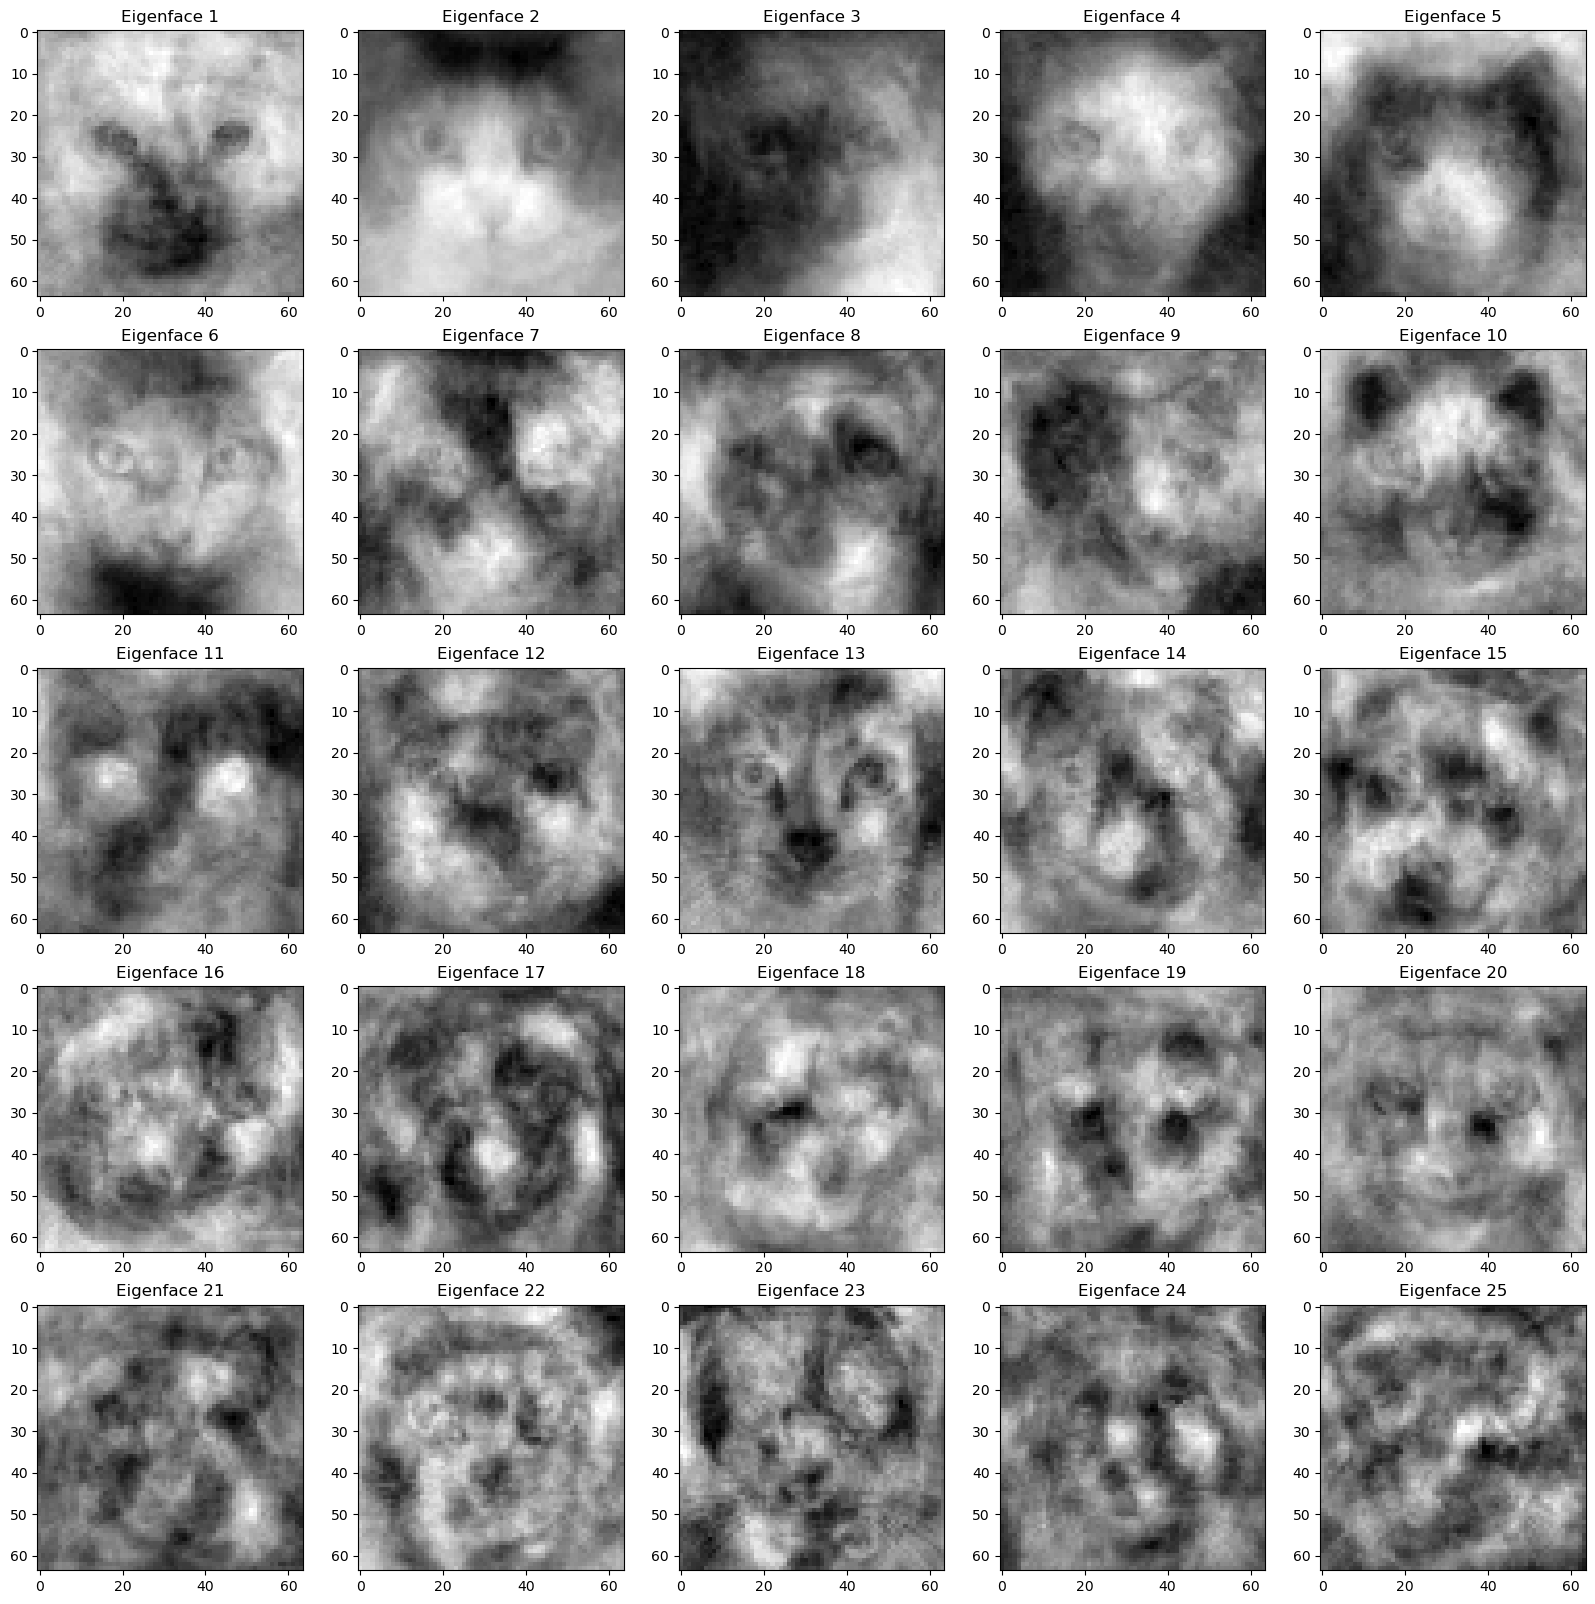

In [86]:
fig, ax = plt.subplots(5, 5, figsize=(20, 20))
for i in range(25):
    ax[i//5, i%5].imshow(corresponding_eigenvectors[:,i].reshape(64,64), cmap='gray')
    ax[i//5, i%5].set_title(f'Eigenface {i+1}')

In [87]:
# PCA
def pca(data, eigenvectors , num_components):
    V = eigenvectors[:,:num_components]
    return data @ V


In [90]:
imgs_pca = pca(imgs_flatten, corresponding_eigenvectors, 2)
print(f"Shape of images after PCA: {imgs_pca.shape}")

Shape of images after PCA: (110, 2)


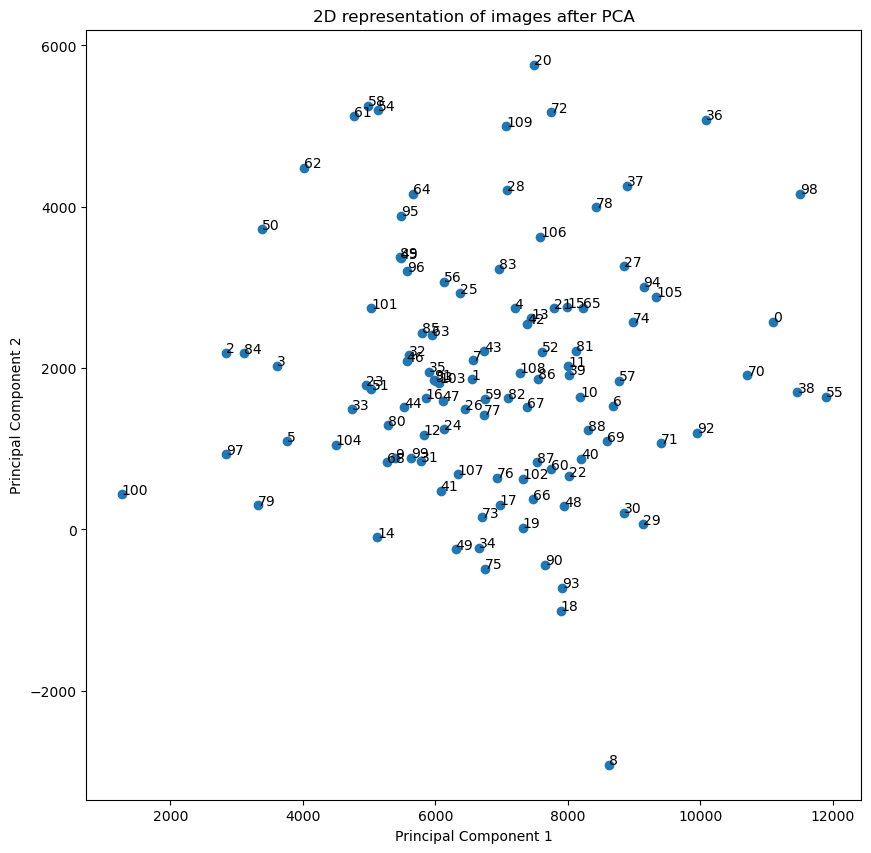

In [92]:
# plot the vector representation all images in 2D space with index as label of each point
plt.figure(figsize=(10, 10))
plt.scatter(imgs_pca[:,0], imgs_pca[:,1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D representation of images after PCA')
for i in range(len(imgs_pca)):
    plt.text(imgs_pca[i,0], imgs_pca[i,1], i)



Based on the images above, it's obvious that image 61, 54 and 58 are close to each other, so the original images should also be similar 

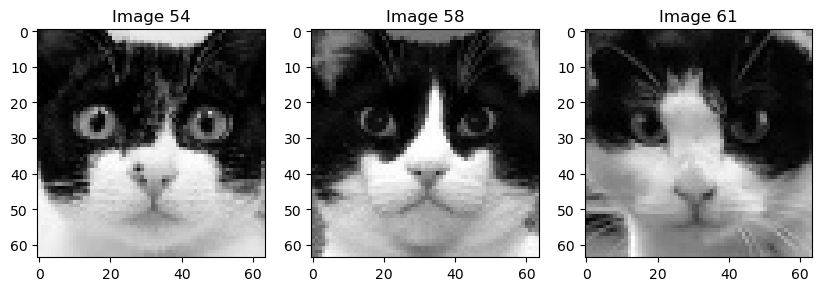

In [93]:
# Similar images
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
similar_img_idx = [54, 58, 61]
for i in range(3):
    ax[i].imshow(imgs[similar_img_idx[i]], cmap='gray')
    ax[i].set_title(f'Image {similar_img_idx[i]}')

In this case some random diffence points are chosen to see whether the original images are different or not

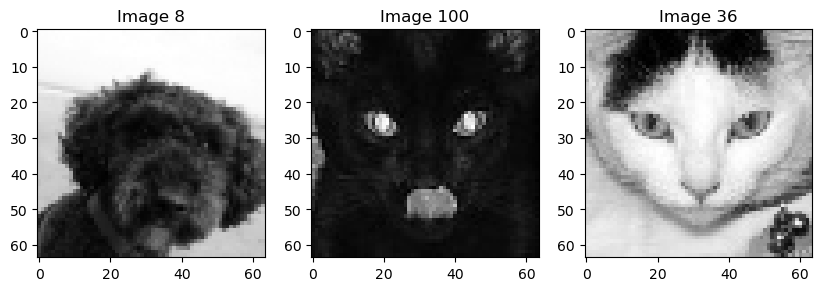

In [99]:
# Different images
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
differe_img_idx = [8, 100, 36]
for i in range(3):
    ax[i].imshow(imgs[differe_img_idx[i]], cmap='gray')
    ax[i].set_title(f'Image {differe_img_idx[i]}')


Recontruct the image from the eigenvectors

In [109]:
def reconstruct_images(img_pca, eigenvectors):
    return img_pca @ eigenvectors[:, :img_pca.shape[1]].T

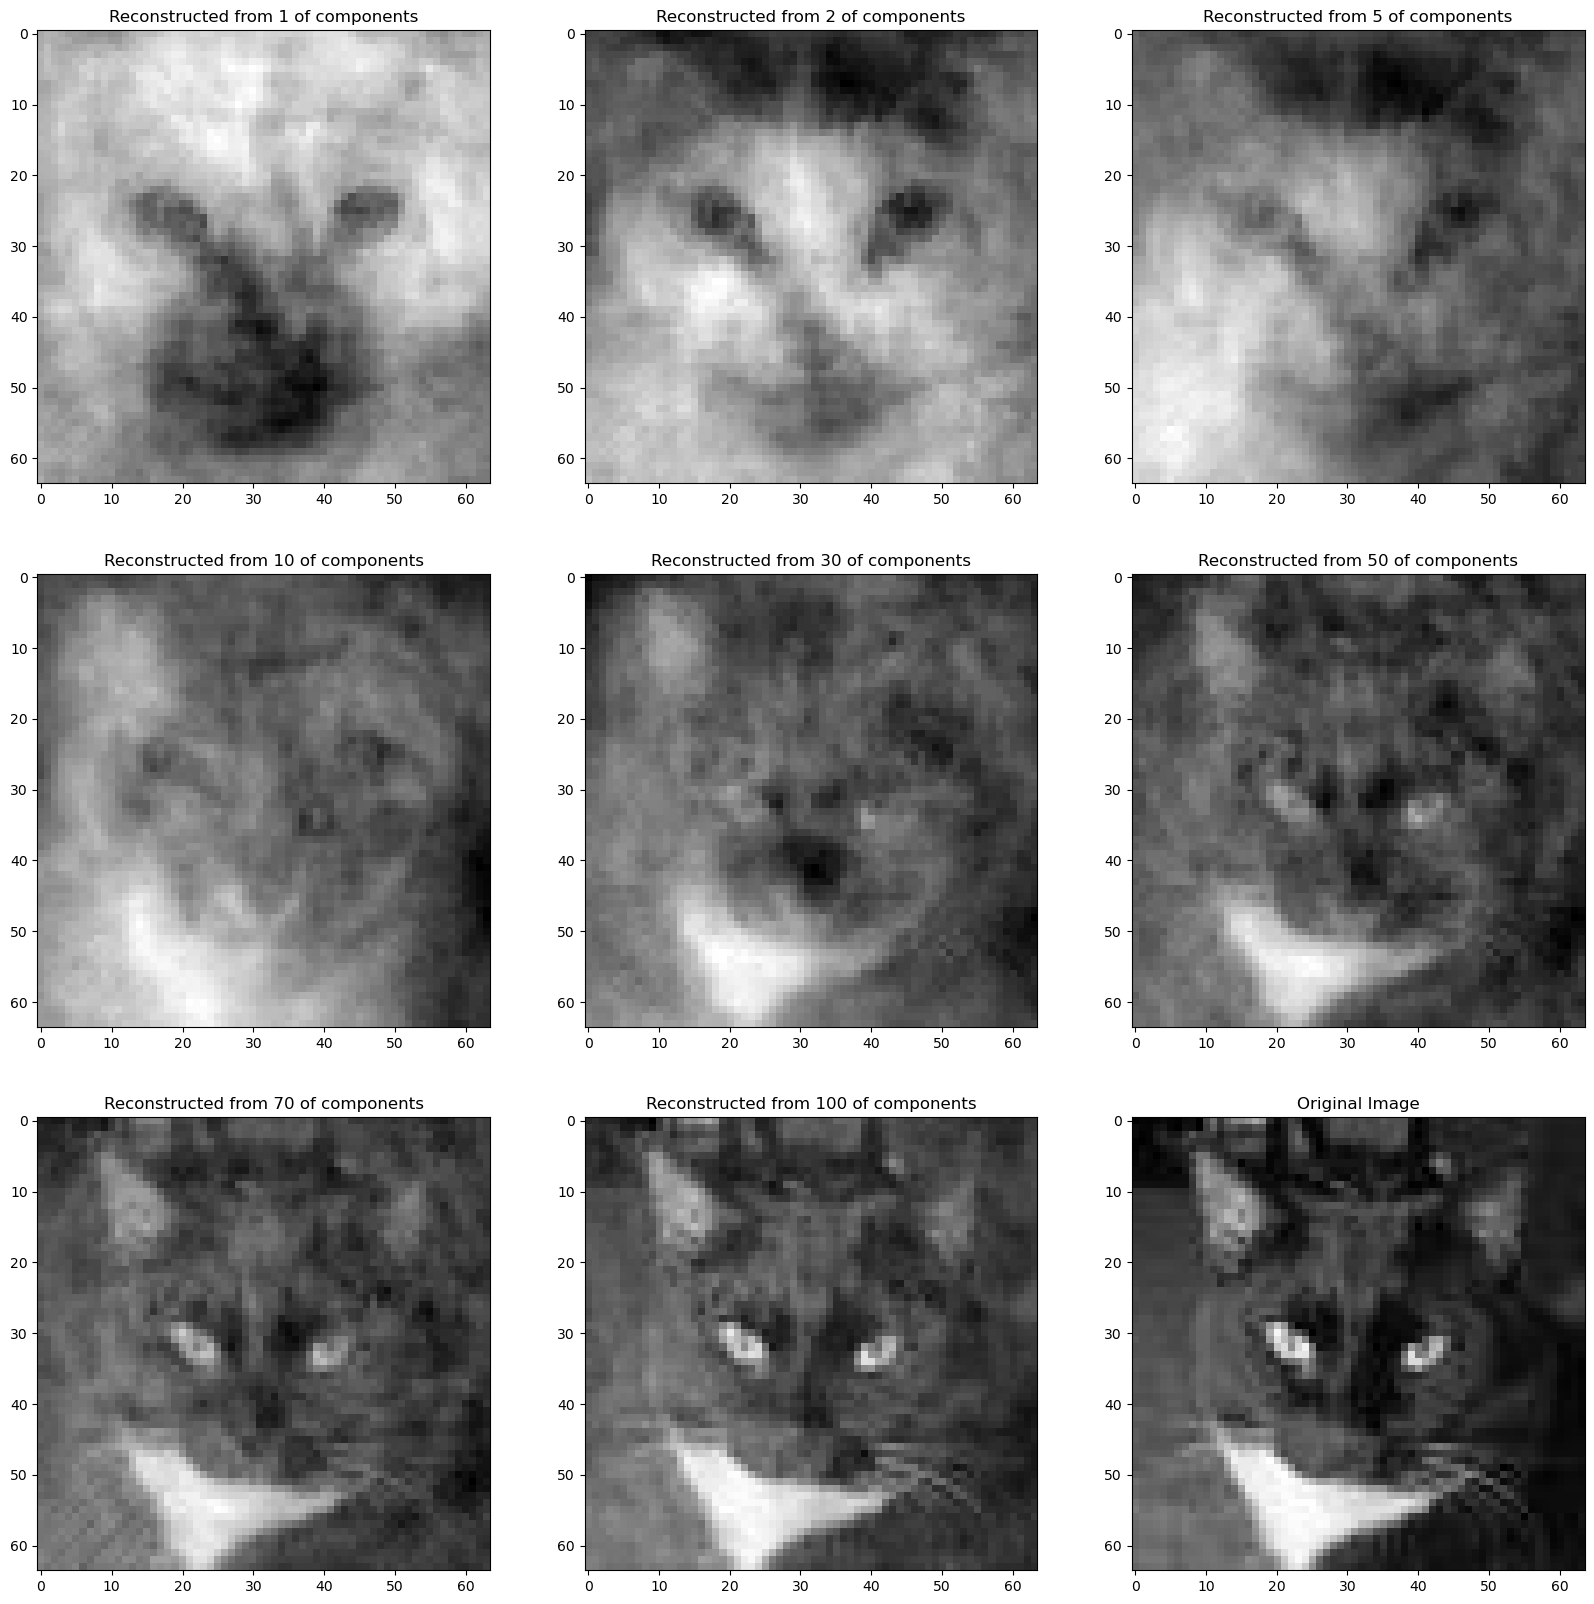

In [116]:
num_component_list = [1, 2, 5, 10, 30, 50, 70, 100]
img_idx = 3
fig, ax = plt.subplots(3, 3, figsize=(20, 20))
ax[2,2].imshow(imgs[img_idx], cmap='gray')
ax[2,2].set_title('Original Image')
for i in range(0, len(num_component_list)):
    img_pca = pca(imgs_flatten, corresponding_eigenvectors, num_component_list[i])
    reconstructed_img = reconstruct_images(img_pca, corresponding_eigenvectors)
    ax[i//3, i%3].imshow(reconstructed_img[img_idx].reshape(64,64), cmap='gray')
    ax[i//3, i%3].set_title(f'Reconstructed from {num_component_list[i]} of components')

Using explained variance to decide how many components are used for the dimensionality reduction.

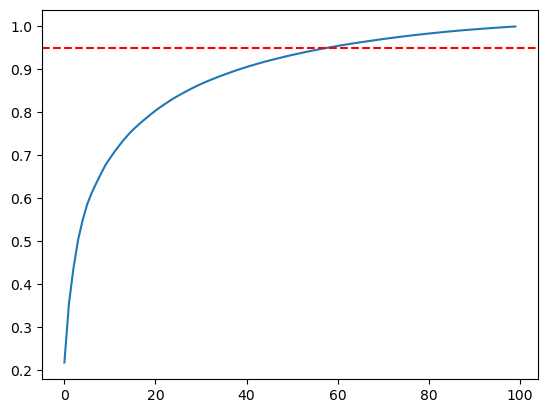

In [122]:
explained_var = biggest_eigenvalues / np.sum(biggest_eigenvalues)
plt.plot(np.cumsum(explained_var))
plt.axhline(0.95, color='red', linestyle='--')

From above plot, we can see that 95% of variance is explained by 58 components, which means we can reduce the dimensionality of the data to 58 components and still keep 95% of the information. Remember the original image has 4096 dimensions. 

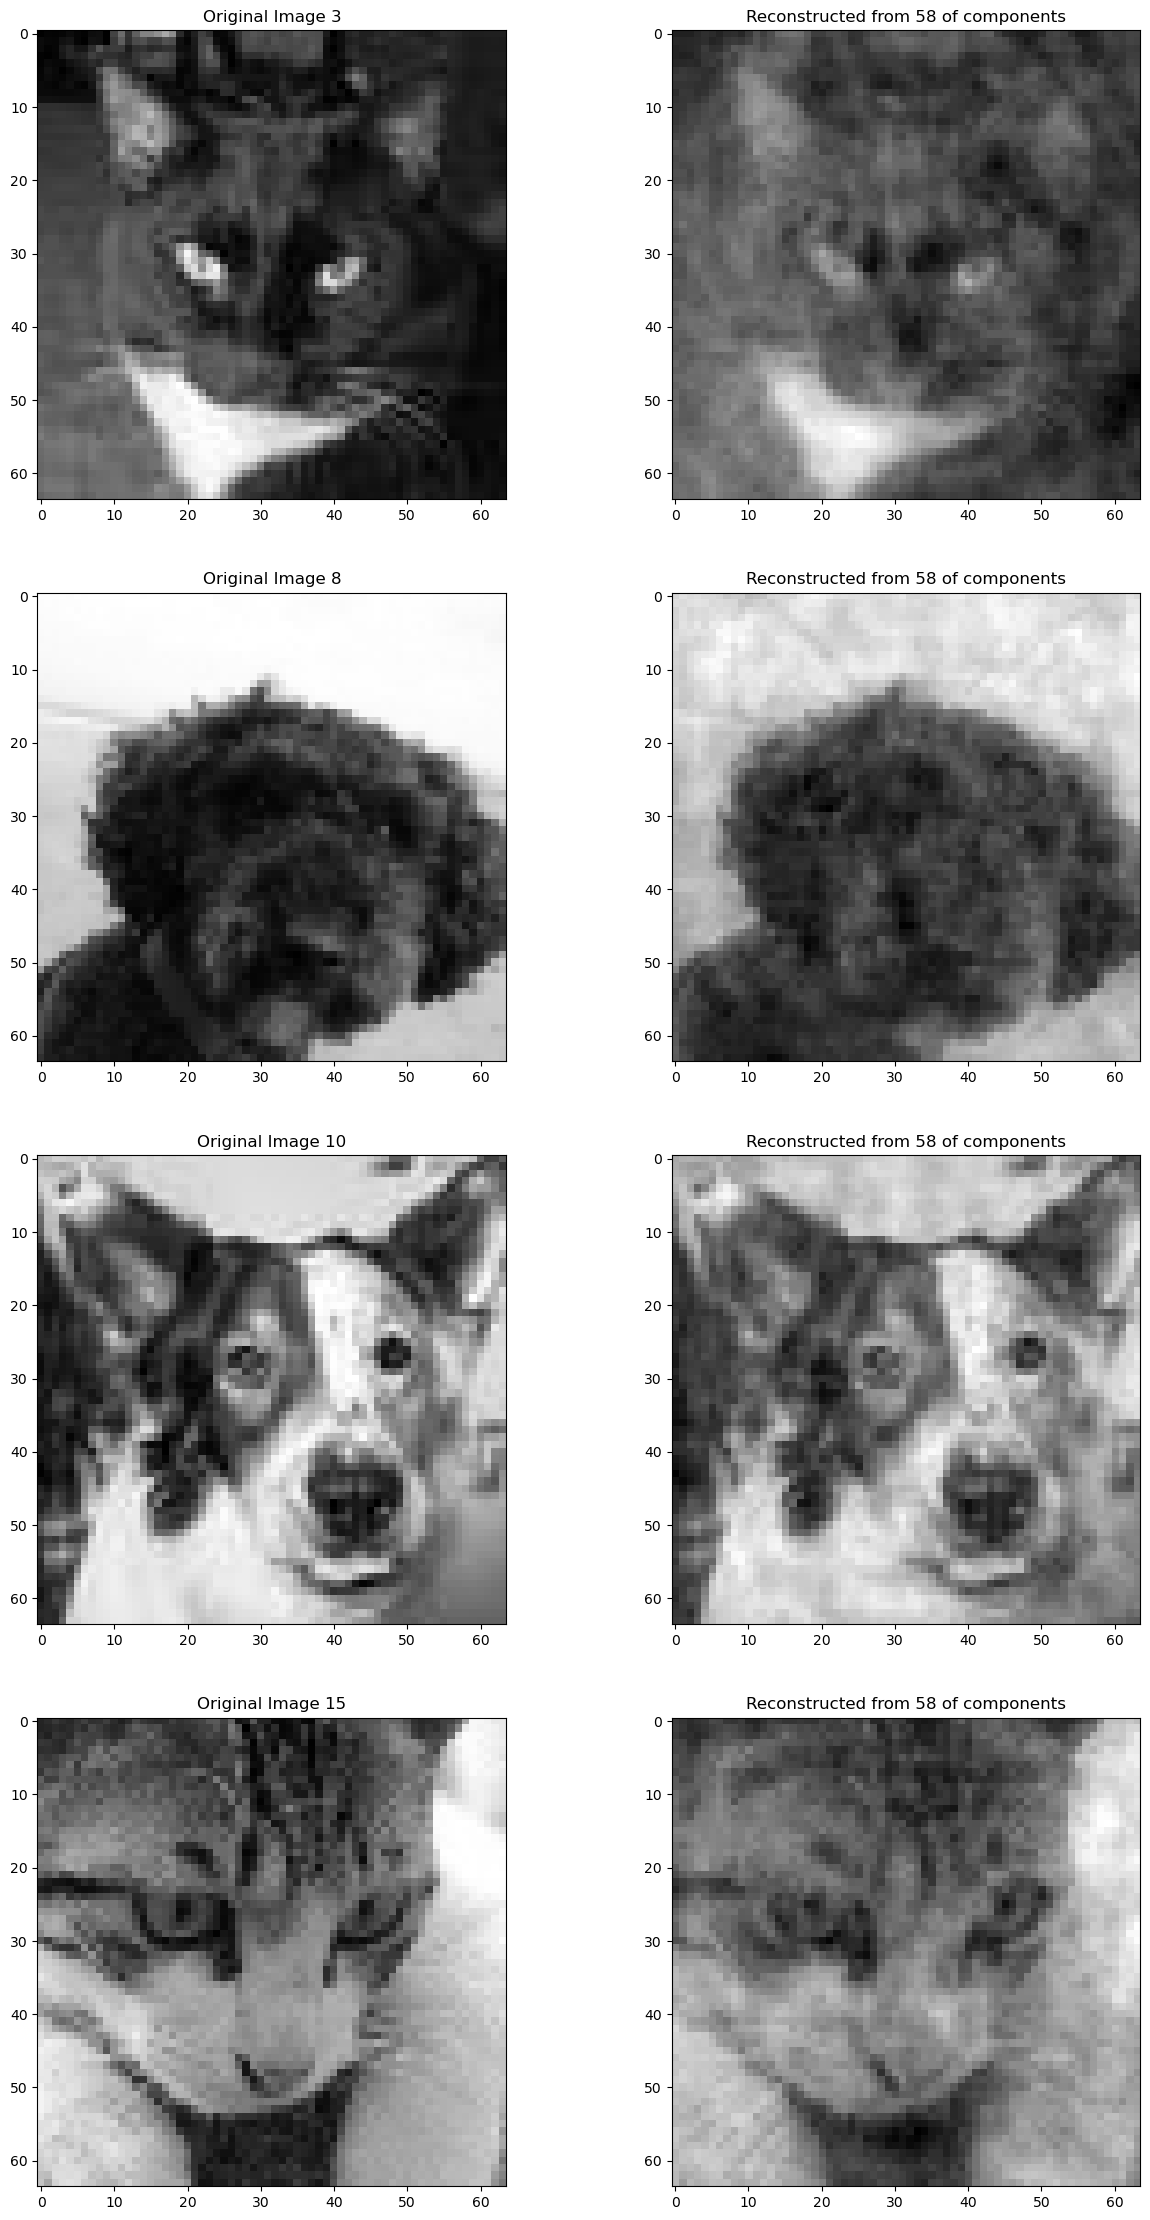

In [121]:
img_set = [3, 8, 10, 15]
fig, ax = plt.subplots(4, 2, figsize=(15, 28))
num_component = 58
for i in range(4):
    ax[i,0].imshow(imgs[img_set[i]], cmap='gray')
    ax[i,0].set_title(f'Original Image {img_set[i]}')
    img_pca = pca(imgs_flatten, corresponding_eigenvectors, num_component)
    reconstructed_img = reconstruct_images(img_pca, corresponding_eigenvectors)
    ax[i,1].imshow(reconstructed_img[img_set[i]].reshape(64,64), cmap='gray')
    ax[i,1].set_title(f'Reconstructed from {num_component} of components')
